# Summary

# Imports

In [1]:
import concurrent.futures
import itertools
import importlib
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import sys
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats

from kmtools import py_tools, sequence_tools

In [2]:
%matplotlib inline

In [3]:
pd.set_option("max_columns", 100)

In [4]:
SRC_PATH = Path.cwd().joinpath('..', 'src').resolve(strict=True)

if SRC_PATH.as_posix() not in sys.path:
    sys.path.insert(0, SRC_PATH.as_posix())

import helper
importlib.reload(helper)

<module 'helper' from '/gpfs/fs0/scratch/p/pmkim/strokach/datapkg/adjacency-net-v2/src/helper/__init__.py'>

# Parameters

In [5]:
NOTEBOOK_PATH = Path('validation_protherm_dataset')
NOTEBOOK_PATH

PosixPath('validation_protherm_dataset')

In [6]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/datapkg/adjacency-net-v2/notebooks/validation_protherm_dataset')

In [7]:
proc = subprocess.run(["git", "rev-parse", "--short", "HEAD"], stdout=subprocess.PIPE)
GIT_REV = proc.stdout.decode().strip()
GIT_REV

'1d63f02'

In [8]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("CI_COMMIT_SHA")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT, NETWORK_NAME

(None, None, None)

In [9]:
DEBUG = "CI" not in os.environ    
DEBUG

True

In [10]:
if DEBUG:
#     NETWORK_NAME = (
# #         "dcn_old_0,3f1b3c1ae15ebc9ee44e47a870b9757b6512462e" + 
#         "dcn_old_0," + 
#         ",".join([
# #         "b76831b2e463bc6075d156d9462031113d260582",
#         "45b7a9397fa2bcd771cbc7179949e12c41cb86a8",
#         "cae42e81a4f32d3d6bb765f1e77e35663a49ae0b",
#         "3f709b656fed89a393f37ef6892403d9ba4c4723",
#         "8469561c501fa5c87a588698d47b4d44b392d17c",
#         "3f1b3c1ae15ebc9ee44e47a870b9757b6512462e",
#         "a01dea2fa87fc92ba21df19a440c4f38945222cd",
#         "2a5b410cc1b9f1e56cc0a3463e02dab1410dff7f",
#         "7bb63b1142b51e6a2e82e7bf17a9e1fac5770da4",
#         "55d2a299afeb4b01d3f54718b6fa1dca18a92a60",
#         "35f38893e35752eda2a89391d885ba307bdf2b9f",
#     ]))
    NETWORK_NAME = "45db9ac454d6ba1ec322f6c9ad56b06402e2a955"
else:
    assert NETWORK_NAME is not None
    
NETWORK_NAME

'45db9ac454d6ba1ec322f6c9ad56b06402e2a955'

In [11]:
# if DEBUG:
#     %load_ext autoreload
#     %autoreload 2

# `DATAPKG`

In [12]:
DATAPKG = {}

In [13]:
DATAPKG['protherm_validaton_dataset'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency-net-v2", "v0.2", "protherm_dataset", "protherm_validaton_dataset.parquet")
)

# Load data

In [14]:
input_file = (
    DATAPKG['protherm_validaton_dataset']
    .resolve(strict=True)
)
input_file

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/databin/adjacency-net-v2/v0.2/protherm_dataset/protherm_validaton_dataset.parquet')

In [15]:
input_df = pq.read_table(input_file).to_pandas()
input_df.head(2)

,filename_wt,chain_id,mutation,cartesian_ddg_beta_nov15_cart_1,ddg_exp,cartesian_ddg_beta_nov16_cart_1,cartesian_ddg_score12_cart_1,cartesian_ddg_talaris2013_cart_1,cartesian_ddg_talaris2014_cart_1,ddg_monomer_soft_rep_design_1,local_filename_wt,structure_id,model_id,qseq,residue_idx_1_corrected,residue_idx_2_corrected,distances,mutation_matches_sequence,qseq_mutation
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 66, 70, 91...","[1.3463744749991646, 4.7287436401778065, 6.389...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 66, 70, 91, 92...","[1.345760255620924, 4.727237880524551, 6.42311...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...


In [16]:
stats.spearmanr(input_df['cartesian_ddg_beta_nov16_cart_1'].values, input_df['ddg_exp'])

SpearmanrResult(correlation=0.5913166222602743, pvalue=0.0)

# Run network

In [17]:
%run trained_networks.ipynb

In [18]:
def mutate_sequence(row):
    sequence = row['sequence']
    wt = row['mutation'][0]
    pos = int(row['mutation'][1:-1])
    mut = row['mutation'][-1]
    sequence_mut = sequence[:pos - 1] + mut + sequence[pos:]
    assert len(sequence) == len(sequence_mut)
    return sequence_mut

In [19]:
input_df['sequence'] = input_df['qseq']
input_df['sequence_mut'] = input_df.apply(mutate_sequence, axis=1)
# input_df['sequence_mut'] = input_df['qseq_mutation']
input_df['adjacency_idx_1'] = input_df['residue_idx_1_corrected']
input_df['adjacency_idx_2'] = input_df['residue_idx_2_corrected']

In [20]:
for network_name in NETWORK_NAME.split(','):
    input_df[f'{network_name}_wt'] = helper.predict_with_network(
        input_df[['sequence', 'adjacency_idx_1', 'adjacency_idx_2', 'distances']]
            .copy(),
        network_state=TRAINED_NETWORKS[network_name]['network_state'],
        network_info=TRAINED_NETWORKS[network_name]['network_info'],
    )
    input_df[f'{network_name}_mut'] = helper.predict_with_network(
        input_df[['sequence_mut', 'adjacency_idx_1', 'adjacency_idx_2', 'distances']]
            .rename(columns={'sequence_mut': 'sequence'}).copy(),
        network_state=TRAINED_NETWORKS[network_name]['network_state'],
        network_info=TRAINED_NETWORKS[network_name]['network_info'],
    )

Network name: 'DCN_45db9ac454d6ba1ec322f6c9ad56b06402e2a955'
Network name: 'DCN_45db9ac454d6ba1ec322f6c9ad56b06402e2a955'


In [21]:
for network_name in NETWORK_NAME.split(','):
    input_df[f'{network_name}_change'] = (
        input_df[f'{network_name}_mut'] -
        input_df[f'{network_name}_wt']
    )

## Save to cache

In [22]:
table = pa.Table.from_pandas(input_df, preserve_index=True)
pq.write_table(
    table,
    OUTPUT_PATH.joinpath("validation_protherm_dataset.parquet"),
    version='2.0',
    flavor='spark',
)

# Analyze

In [23]:
data_ref = [
    ('Provean', 0.25, None),
    ('FoldX', 0.48, None),
    ('ELASPIC', 0.54, None),
    ('Rosetta', 0.59, None),  # cartesian_ddg_beta_nov16_cart_1
]

data_net = []

for network_name in NETWORK_NAME.split(','):
    corr, pvalue = stats.spearmanr(
        input_df[f'{network_name}_change'],
        -input_df['ddg_exp']
    )
    data_net.append((network_name, corr, pvalue))
    
data_net.sort(key=lambda x: x[1], reverse=True)

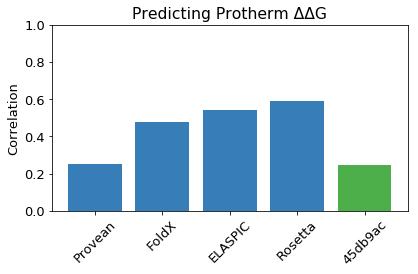

In [24]:
cmap = plt.get_cmap("Set1")

feature_names = {}

df = pd.DataFrame(data_ref + data_net, columns=['feature', 'correlation', 'pvalue'])
df

# fg, axs = plt.subplots(figsize=(6, 3))

with plt.rc_context(rc={'figure.figsize': (6, 4), 'font.size': 13}):
    x = np.arange(len(df))
    c = [cmap(2) if f in NETWORK_NAME.split(',') else cmap(1) for f in df['feature']]
    plt.bar(x, df['correlation'], color=c)
    plt.xticks(x, [feature_names.get(f, f[:7]) for f in df['feature'].values], rotation=45)
    plt.ylim(0.4, 1)
    plt.ylabel("Correlation")
    plt.title("Predicting Protherm ΔΔG")
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig(OUTPUT_PATH.joinpath("validation_protherm_correlations.png"), dpi=300, bbox_inches="tight")
    plt.savefig(OUTPUT_PATH.joinpath("validation_protherm_correlations.svg"), bbox_inches="tight")

In [25]:
NETWORK_NAME

'45db9ac454d6ba1ec322f6c9ad56b06402e2a955'